In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [2]:
np.random.seed(2021)

In [3]:
# Subprocedures for algorithm

def epsilon_neighbor(d, eps=1.0):
    return (d < eps**2).astype(int)

def gauss_sim(d, sigma=1.0):
    return np.exp(-d/sigma**2)

def getSimilarity(data, weighted=True):
    dist = np.square(data - np.tile(data, (data.shape[0],1)).T)
    if weighted:
        return gauss_sim(dist)
    else:
        return epsilon_neighbor(dist)

def getLaplacian(W):
    return np.diag(np.sum(W, axis=0)) - W

In [4]:
# Algorithm

def spectral_clustering(data, k, weighted=True):
    W = getSimilarity(data, weighted=weighted)
    L = getLaplacian(W)
    
    lam, U = np.linalg.eigh(L)
    sorted_ind = np.argsort(lam)
    U_best = U[:, sorted_ind[:k]]
    
    kmeans = KMeans(n_clusters=k).fit(U_best)
    #pred_clusters = reorderLabels(kmeans.labels_)

    return kmeans.labels_

In [5]:
# For evaluation

def getLoss(data, label, return_cluster_loss=False):
    all_loss = []
    for c in np.unique(label):
        #cluster_indices = np.where(c == pred)
        cluster_data = data[c == label]
        cluster_dist = np.square(cluster_data - np.tile(cluster_data, (cluster_data.shape[0],1)).T)
        cluster_loss = np.sum(cluster_dist)
        all_loss.append(cluster_loss)
    
    return sum(all_loss) if not return_cluster_loss else (sum(all_loss), all_loss)

# Unweighted Graph Visualization

In [6]:
n = 12
centers = [2,4,6,8]
sigma = 0.4
k = len(centers)

gt_label_indices = np.random.permutation(np.arange(n))
gt_labels = np.repeat(np.arange(k), n//k)[gt_label_indices]

cluster_data = np.stack([np.random.normal(loc=m, scale=sigma, size=n//k) for m in centers])
data = cluster_data.reshape(-1)[gt_label_indices]

In [7]:
W = getSimilarity(data, weighted=False)
W.shape

(12, 12)

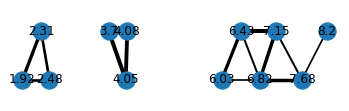

In [8]:
# Visualize sim graph
import networkx as nx

G = nx.Graph()
G.add_nodes_from(np.arange(n))
edges = np.stack(np.where(W > 0)).T
G.add_edges_from(edges)

# Adjust node position
y_pos = np.zeros(n)
y_pos[np.arange(1, n, step=2)] = 1#np.arange(n//2)+1
y_pos_map = dict(zip(np.argsort(data), y_pos))
permuted_y_pos = [y_pos_map[i] for i in range(n)]

# Set axis scale equal
plt.ylim(-0.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

# Adjust edges width
weights = getSimilarity(data, weighted=True)

posdict = dict(zip(np.arange(n), tuple(zip(data, permuted_y_pos))))
labeldict = dict(zip(np.arange(n), np.around(data, 2)))
nx.draw(G, labels=labeldict, with_labels=True, width=(weights[W > 0] - 0.2)*5, pos=posdict)


# Toy Example Dataset

In [9]:
n = 200

centers = [2,4,6,8]
sigma = 0.4
k = len(centers)


In [10]:
gt_label_indices = np.random.permutation(np.arange(n))

gt_labels = np.repeat(np.arange(k), n//k)[gt_label_indices]

In [11]:
cluster_data = np.stack([np.random.normal(loc=m, scale=sigma, size=n//k) for m in centers])

data = cluster_data.reshape(-1)[gt_label_indices]

data.shape

(200,)

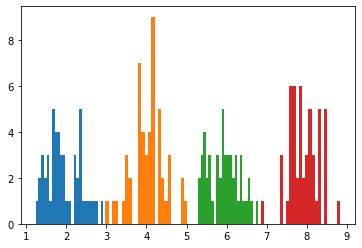

In [12]:
n_bins = n//2

for i in range(k): 
    plt.hist(cluster_data[i], bins=n_bins//k)

# Weighted Graph & Algorithm

In [13]:
W = getSimilarity(data, weighted=True)
W.shape

(200, 200)

In [14]:
L = getLaplacian(W)
L.shape

(200, 200)

In [15]:
lam, U = np.linalg.eigh(L)
sorted_ind = np.argsort(lam)

num_ref = k 
smallest_ind = sorted_ind[:k+num_ref]
lam[smallest_ind]

array([-7.12281168e-15,  1.44110561e+00,  4.63013242e+00,  1.04994300e+01,
        2.29301620e+01,  2.77582679e+01,  3.10289209e+01,  3.19157452e+01])

In [16]:
U[:,smallest_ind[:k]]
U_best = U[:,smallest_ind[:k]]

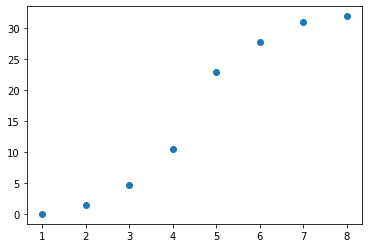

In [17]:
# Eigenvalue plot

plt.scatter(np.arange(k+num_ref)+1, lam[smallest_ind])

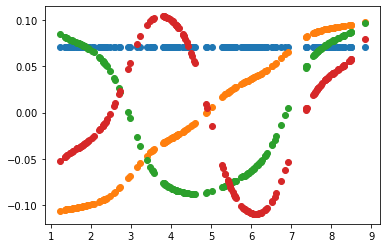

In [18]:
# Eigenvector plots

for i in range(k): 
    u = U_best[:,i]
    plt.scatter(data, u)

# Clustering Result

In [19]:
kmeans = KMeans(n_clusters=k).fit(U_best)
pred = kmeans.labels_

In [20]:
getLoss(data, pred)

3213.8677127128576

In [21]:
getLoss(data, gt_labels)

3228.4830498418632

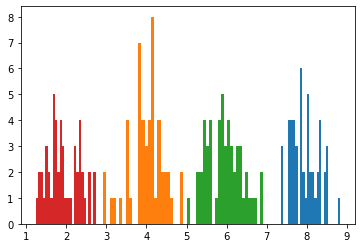

In [22]:
for c in np.unique(pred): 
    plt.hist(data[c==pred], bins=n_bins//k)

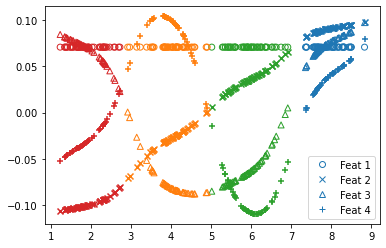

In [64]:
# Feature vector pattern of each cluster
clus_marker = [plt.rcParams['axes.prop_cycle'].by_key()['color'][i] for i in [3,2,0,1]]
feat_marker = ['o', 'x', '^', '+']

for c in np.unique(pred): 
    """
    x = np.tile(data[c==pred], k)
    y = np.concatenate([U_best[c==pred,i] for i in range(k)])
    plt.scatter(x, y)
    """
    for i in range(k):
        if feat_marker[i] in ['o', '^']:
            plt.scatter(data[c==pred], U_best[c==pred,i], color=clus_marker[c], marker=feat_marker[i], facecolors='none')
        else:
            plt.scatter(data[c==pred], U_best[c==pred,i], color=clus_marker[c], marker=feat_marker[i])
            
plt.legend([])
import matplotlib.lines as mlines

legend_feat1 = mlines.Line2D([], [], marker='o', linestyle='None', markerfacecolor="none", label='Feat 1')
legend_feat2 = mlines.Line2D([], [], marker='x', linestyle='None', label='Feat 2')
legend_feat3 = mlines.Line2D([], [], marker='^', linestyle='None', markerfacecolor="none", label='Feat 3')
legend_feat4 = mlines.Line2D([], [], marker='+', linestyle='None', label='Feat 4')

plt.legend(handles=[legend_feat1, legend_feat2, legend_feat3, legend_feat4])

In [24]:
pred = spectral_clustering(data, k)

In [25]:
# TODO: Implement local scaling, add harder example, take time on big example

# Multi-local-scale Example

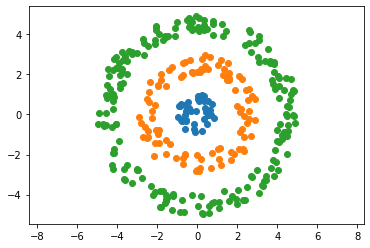

In [95]:
N = [40, 100, 200]
R_range = [(0,1), (2,3), (4,5)]

k = len(N)

plt.axis('equal')

for i in range(k):
    r_min, r_max = R_range[i]
    n = N[i]
    r = np.sqrt(np.random.uniform(r_min**2, r_max**2, n))
    theta = np.random.uniform(0,2*np.pi,n)

    points = np.stack([r * np.cos(theta), r * np.sin(theta)])
    plt.scatter(points[0], points[1])

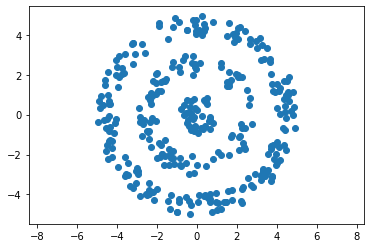

In [100]:
N = [40, 100, 200]
R_range = [(0,1), (2,3), (4,5)]

k = len(N)

plt.axis('equal')

all_points = np.array([[],[]])

for i in range(k):
    r_min, r_max = R_range[i]
    n = N[i]
    r = np.sqrt(np.random.uniform(r_min**2, r_max**2, n))
    theta = np.random.uniform(0,2*np.pi,n)

    points = np.stack([r * np.cos(theta), r * np.sin(theta)])
    all_points = np.concatenate([all_points, points], axis=1)

plt.scatter(all_points[0], all_points[1])

In [139]:
np.random.seed(2021)

n = 500
R_range = [(0,1), (2,3), (4,5)]
k = len(R_range)

theta = np.random.uniform(0,2*np.pi,n)

intv_len = np.array([R_range[i][1]**2 - R_range[i][0]**2 for i in range(k)])
total_length = np.sum(intv_len)

print(intv_len)

cum_len = np.cumsum(intv_len)


print(cum_len)

true_Rs = []

cluster_size = [0] * k
cluster_indices = [[] for i in range(k)]

R_sq = np.random.uniform(0, total_length, n)
for i, r_sq in enumerate(R_sq):
    
    #print(r_sq)
    cluster = np.where(r_sq < cum_len)[0][0]
    #print(intv)
    #cluster = intv[0]
    #print(cluster)
    
    r_min, r_max = R_range[cluster]
    intv_offset = r_sq - cum_len[cluster-1] if cluster != 0 else r_sq
    
    
    #print(intv_offset)
    assert(intv_offset > 0)
    #print(r_min**2)
    
    true_r_sq = r_min**2 + intv_offset
    
    #print(true_r_sq)
    assert(true_r_sq > 0)
    #print()
    
    true_Rs.append(true_r_sq)
    cluster_size[cluster] += 1
    
    cluster_indices[cluster].append(i)
    

#R_range = [(0,1), (2,3), (4,5)]
#r = np.sqrt(np.random.uniform(r_min**2, r_max**2, n))
#print(true_Rs)
r = np.sqrt(np.array(true_Rs))
#print(true_Rs)
#print(r)
print(cluster_size)
#print(cluster_indices)
cluster_indices = np.array(cluster_indices)

[1 5 9]
[ 1  6 15]
[34, 169, 297]


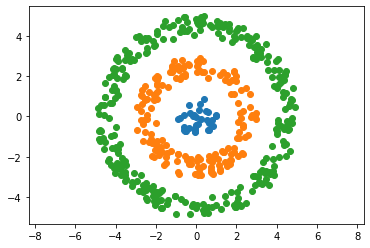

In [140]:
plt.axis('equal')

points = np.stack([r * np.cos(theta), r * np.sin(theta)])

for i in range(k):
    clus_points = points[:, cluster_indices[i]]
    plt.scatter(clus_points[0], clus_points[1])

In [ ]:
for i in range(k):
    r_min, r_max = R_range[i]
    